In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
import pickle


# Sistema de predicción de ventas

Queremos establecer el almacén de nuestra empresa en otra localización y necesitamos estimar el ritmo de las ventas, que desde la creación de la empresa ha ido en aumento, para los próximos meses, a fin de proveer el espacio que necesitaremos.

# Paso 1: Carga del conjunto de datos

El conjunto de datos se puede encontrar en esta carpeta de proyecto bajo el nombre sales.csv. Puedes cargarlos en el código directamente desde el siguiente enlace:

In [283]:
df = pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=2546&path=sales.csv")
df.head(20)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
5,2022-09-08 17:10:08.079328,60.081865
6,2022-09-09 17:10:08.079328,68.466704
7,2022-09-10 17:10:08.079328,67.765106
8,2022-09-11 17:10:08.079328,70.512261
9,2022-09-12 17:10:08.079328,74.656453


# Paso 2: Construye y analiza la serie temporal

Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:

¿Cuál es el tensor de la serie temporal?
¿Cuál es la tendencia?
¿Es estacionaria?
¿Existe variabilidad o presencia de ruido?

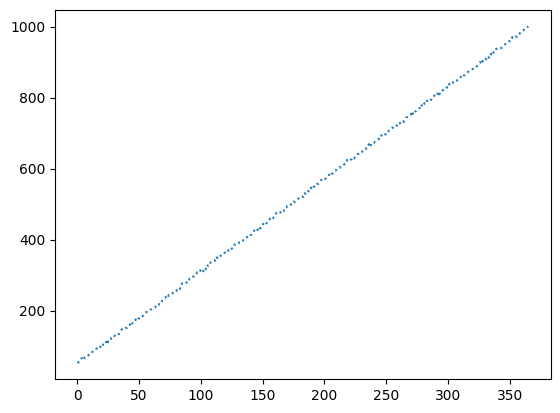

In [284]:
# visualisacion de las ventas reales por dia
ypoints = df["sales"]

plt.plot(ypoints, linestyle = 'dotted')
plt.show()

se observa que las ventas tienen una tendencia a crecer linealmente conforme al paso de los dias.

## limpieza de los datos

primero convertimos nuestra columna dates a formato solo de fecha

In [285]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [286]:
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [287]:
# convertir el date en el indice del dataframe
df = df.set_index('date')

In [288]:
# dejar el indice solo con la fecha eliminando las horas
df.index = df.index.normalize()

In [289]:
df.head(5)

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


En este caso, la dimensión temporal estará compuesta por el año mes y dia(date) y el dato que observaremos a lo largo del tiempo será el número de ventas (sales).

In [290]:
ts = df["sales"]

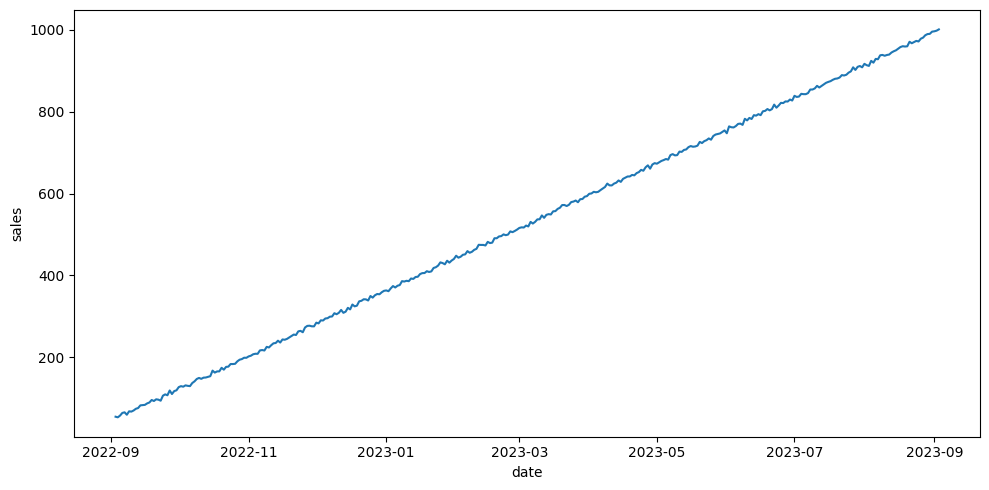

In [291]:
#analizando los datos con el indice fecha

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = ts)
plt.tight_layout()
plt.show()

Paso 2. Análisis de una serie temporal
Para analizar una serie temporal, como vimos en la teoría, debemos estudiar varios parámetros:

Tendencia: Se aprecia una tendencia ascendente, lo que indica que el número de ventas ha aumentado a lo largo del tiempo.

Estacionalidad: no se observa una  estacionalidad marcada.. solo se logra observar una inclinacion siempre ascendente.

Variabilidad: Se observan muy pocos puntos de variabilidad en donde las ventas bajan un poco en comparacion con el dia  anterior y luego sigue su comportamiento ascendiente

Puntos de inflexión: Dependiendo del año, el aumento en el número de pasajeros no es regular y a veces se producen variaciones en la pendiente; estos son, puntos de inflexión.
A través de un análisis visual podríamos ser capaces de estimar estas métricas a ojo, pero siempre es mejor orientar el análisis a los datos matemáticos. Para la labor de realizar predicciones sobre series temporales y analizarlas, nos apoyaremos en la librería statsmodels:

Descomposición de la serie
La descomposición de una serie temporal es un proceso estadístico que separa de una serie de tiempo en varios elementos diferenciados. Cada uno de estos componentes representa una parte de la estructura subyacente de la serie temporal. La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

Utilizamos la función seasonal_decompose de la biblioteca statsmodels para descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuos.

## Asegurar que la frecuencia temporal sea diaria

ARIMA necesita una frecuencia constante. Si faltan fechas, deben completarse.

In [292]:

ts = ts.asfreq('D')
ts

date
2022-09-03      55.292157
2022-09-04      53.803211
2022-09-05      58.141693
2022-09-06      64.530899
2022-09-07      66.013633
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Freq: D, Name: sales, Length: 366, dtype: float64

aqui podemos observar que nuestros  datos comienzan con fecha en 3 de septiembre de 2022 y terminan un 03 de septiempre de 2023 y tenemos una longitud de 366 datos, lo que nos indica que no hacen falta datos, en caso de datos faltantes tendriamos que buscar la manera de rellenar esos datos

## Descomposición de la serie

La descomposición de una serie temporal es un proceso estadístico que separa de una serie de tiempo en varios elementos diferenciados. Cada uno de estos componentes representa una parte de la estructura subyacente de la serie temporal. La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

Utilizamos la función seasonal_decompose de la biblioteca statsmodels para descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuos.

en este caso tenemos un dataset con registros diarios por un año, tomaremos  nuestro periodo como semanal por lo tanto period = 7

In [293]:
decomposition = seasonal_decompose(ts, period = 7)
decomposition

## Análisis de la tendencia

La tendencia se refiere a la dirección general en la que se mueven los datos. Para acceder a su información recurrimos al componente trend del resultado decomposition.

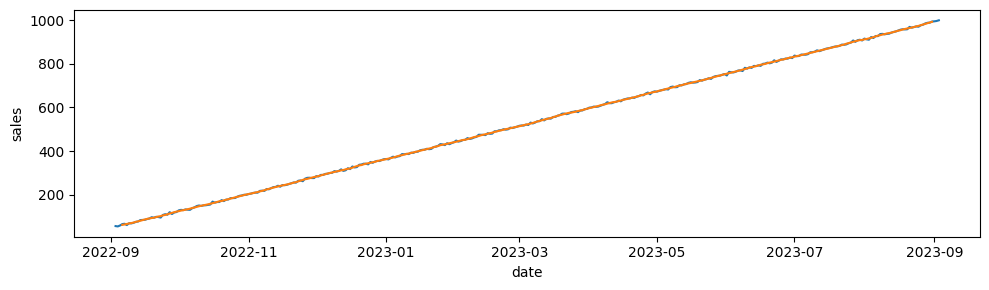

In [294]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 3))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Se confirma lo observado: una clara tendencia positiva a lo largo de los dias

## Análisis de la estacionalidad

La estacionalidad se refiere a los patrones repetitivos en los datos. Para acceder a su información recurrimos al componente seasonal del resultado decomposition.

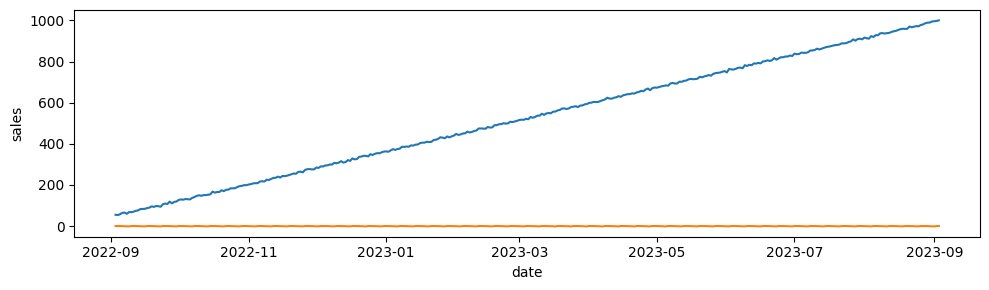

In [295]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 3))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada Prueba de Dickey-Fuller (Dickey-Fuller test), que es un contraste de hipótesis en el que la hipótesis nula es que la serie no es estacionaria, y la alternativa, que es estacionaria:

In [296]:

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula no se puede rechazar y tomaremos esta serie como no estacionaria.

## Análisis de la variabilidad

La variabilidad implica el estudio de los residuos: que es cómo fluctúan los datos una vez se ha estudiado la tendencia y la estacionalidad. Para acceder a su información recurrimos al componente resid del resultado decomposition.



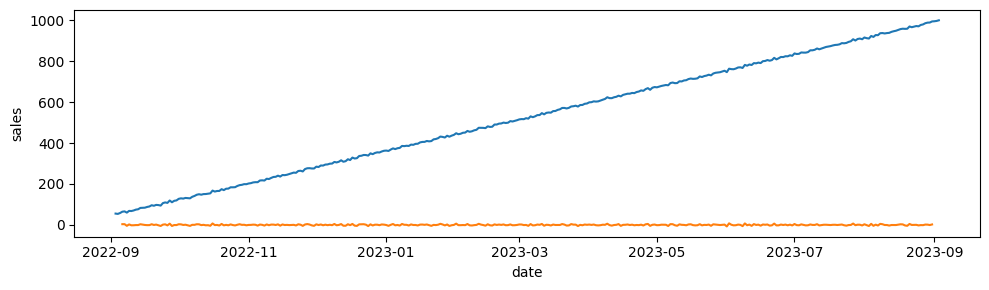

In [297]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 3))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

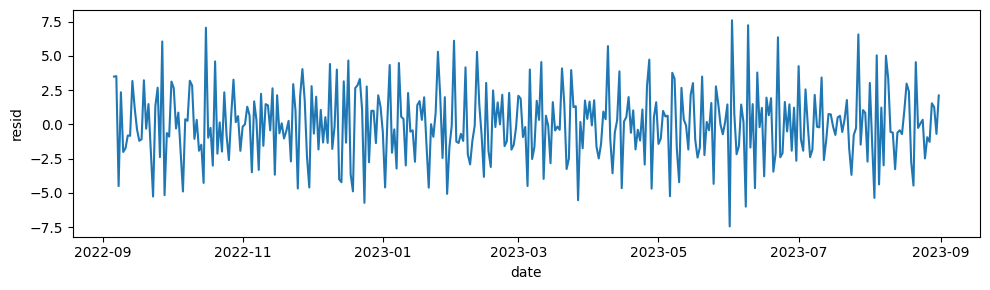

In [298]:
# observando solo los residuos
fig, axis = plt.subplots(figsize = (10, 3))

sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

se observa que el cambio en ventas suele estar entre -7.5 y 7.5 de diferencias entre una referencia y su referencia anterior, con mas picos positivos, por tal motivo observamos una tendencia lineal creciente.

(yo tome el periodo de 7 dias entonces mi referencia es diaria o semanal? por fa comentamelo cuando corrijas )

## Análisis de la autocorrelación

La autocorrelación es la correlación de una serie de tiempo con una copia retrasada de sí misma. Este gráfico nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores.

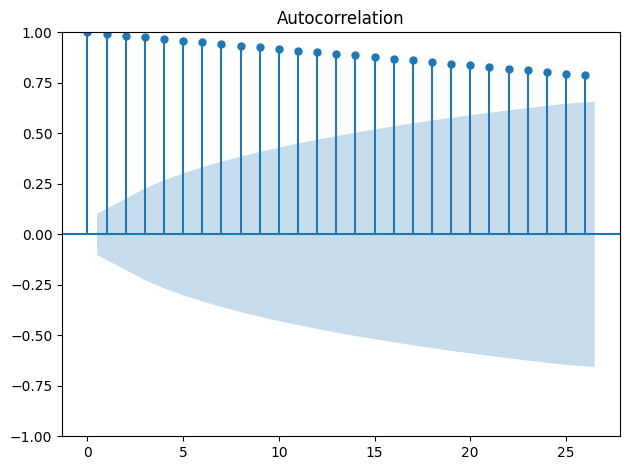

In [299]:
plot_acf(ts)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye en muy poca medida a lo largo del tiempo

# Paso 3: Entrenamiento del modelo

Un modelo consta de tres hiperparámetros:

p: El orden del componente autorregresivo (AR).

d: El grado de diferenciación necesario para hacer la serie de tiempo estacionaria.

q: El orden del componente de media móvil (MA).

El estudio de estos hiperparámetros escapa nuestra función, ya que es un análisis puramente matemático-estadístico. Hoy en día existen herramientas que nos facilitan la vida estimando de forma interna los hiperparámetros más apropiados y generando el mejor modelo posible, como el paquete pmdarima y su función auto_arima. Lo único que tenemos que considerar es que para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria, y como en el caso de esta serie no lo es, debemos transformarla:

In [300]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Ahora la serie si que lo es, tenemos un p-value con 5.21e-16 lo que indica que es menor a 0.05 por tal motivo se rechaza la hipotesis nula de Dickey-Fuller y  se aprueba la alternativa (Es estacionaria), y podemos aplicar el método ARIMA automático:

In [301]:
model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 7)

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1966.396, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1970.972, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=1968.120, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=1968.220, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=1966.919, Time=0.12 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=1965.376, Time=0.53 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=1965.211, Time=0.71 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=1963.937, Time=0.94 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=1967.822, Time=0.18 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=2094.918, Time=0.43 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=1911.553, Time=0.55 sec
 ARIMA(2,0,0)(0,0,2)

Como podemos ver, la función hace una búsqueda en el espacio de soluciones posible para estimar los mejores parámetros. En este caso tendríamos un ARIMA(2,0,1) El modelo que devuelve esta función es totalmente usable, como cualquier otro que hayamos visto, y su función summary() devuelve información estadística y sobre su rendimiento que tiene gran valor

In [302]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  365
Model:             SARIMAX(2, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -910.863
Date:                                Fri, 05 Dec 2025   AIC                           1837.726
Time:                                        13:11:25   BIC                           1868.925
Sample:                                    09-04-2022   HQIC                          1850.125
                                         - 09-03-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.1892      0.477     10.869      0.000       4.253       6.125
ar.L1         -0.0774      0.054     -1.436      0.151      -0.183       0.028
ar.L2          0.0539      0.059      0.918      0.359      -0.061       0.169
ma.L1         -0.9773      0.018    -55.002      0.000      -1.012      -0.942
ar.S.L7       -0.9504      0.075    -12.606      0.000      -1.098      -0.803
ma.S.L7        1.1090      0.092     12.025      0.000       0.928       1.290
ma.S.L14       0.1809      0.054      3.358      0.001       0.075       0.286
sigma2         8.6913      0.697     12.474      0.000       7.326      10.057
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.77   Prob(JB):                         0.92
Heteroskedasticity (H):               0.87   Skew:                             0.04
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Paso 4: Predice con el conjunto de test



Una vez se ha entrenado el modelo, se puede utilizar para predecir a futuro (predeciremos los siguientes 10 meses)

In [303]:
forecast = model.predict(10)
forecast

2023-09-04    2.082317
2023-09-05    3.051095
2023-09-06    1.940035
2023-09-07    3.235950
2023-09-08    1.729522
2023-09-09    3.064951
2023-09-10    2.353270
2023-09-11    2.286203
2023-09-12    2.548106
2023-09-13    2.733508
Freq: D, dtype: float64

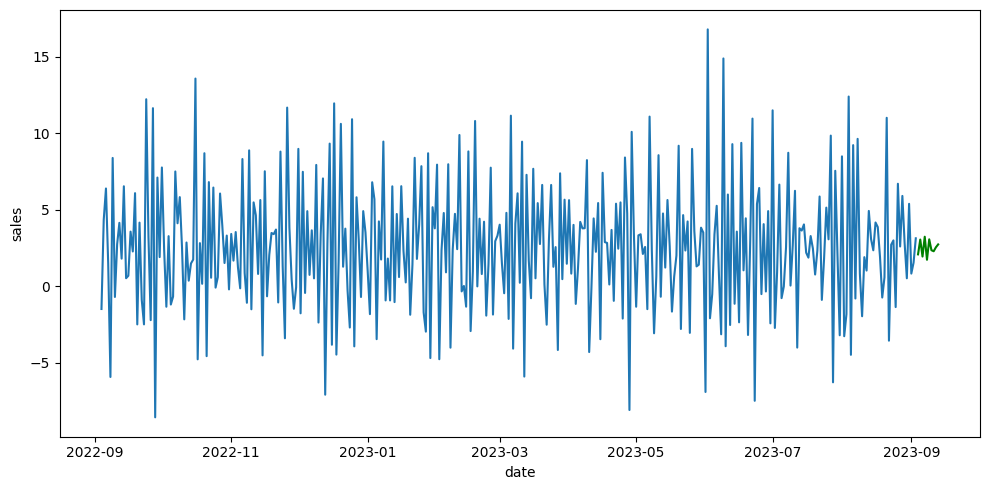

In [304]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

# Paso 5: Guarda el modelo

In [305]:
with open("/workspaces/betaniammc-machine-learning/models/serie_de_tiempo_model.pkl", "wb") as file:
    pickle.dump(model, file)